In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import urllib.request
import os
import gzip
import shutil
import logging
import random
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, AutoModel
from gensim.models import Word2Vec

# 启用交互模式，便于实时更新图表
plt.ion()

# 设置日志记录，同时输出到文件
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
fh = logging.FileHandler("training.log")
fh.setFormatter(formatter)
logger.addHandler(fh)

# 设置随机种子
seed = 30
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# 设置计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 检测可用GPU数量
num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    logger.info(f"Found {num_gpus} GPUs! Using distributed training.")
    use_multi_gpu = True
else:
    logger.info(f"Found {num_gpus} GPU. Using single GPU training.")
    use_multi_gpu = False

# -------------------------------
# 多GPU设置
# -------------------------------
def setup_ddp(rank, world_size):
    """
    设置分布式数据并行训练
    """
    if use_multi_gpu:
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        torch.distributed.init_process_group(backend='nccl', init_method='env://', 
                                            world_size=world_size, rank=rank)
        torch.cuda.set_device(rank)

def cleanup_ddp():
    """
    清理分布式训练环境
    """
    if use_multi_gpu and torch.distributed.is_initialized():
        torch.distributed.destroy_process_group()

# -------------------------------
# 加载 word2vec 模型和分词器（异常处理）
# -------------------------------
# logger.info("Loading CodeBERT model and tokenizer...")
# try:
#     codebert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
#     codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")
#     codebert_model.to(device)
#     codebert_model.eval()
#     logger.info("CodeBERT loaded successfully!")
# except Exception as e:
#     logger.error("Failed to load word2vec model. Error: " + str(e))
#     raise e

# -------------------------------
# 超参数设置（针对 RTX 4090 优化后）
# -------------------------------
EMBEDDING_DIM = 300  # embedding 输出维度
W2VFILE = "./autodl-tmp/w2v.model"
W2VVECFILE = "./autodl-tmp/vec.npy"
FILTER_SIZES = [3, 4, 5]
NUM_FILTERS = 150
HIDDEN_DIM = 256
MATCH_COUNT = 240
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.0005
EPOCHS = 10
K_FOLDS = 10
BATCH_SIZE = 2048
ACCUMULATION_STEPS = 1
MODEL_SAVE_PATH = "./models/"
TOP_K = 5
BATCH_MAX_LENGTH = 150

# -------------------------------
# 数据路径设置
# CSV 格式：第1列忽略，第2列为标签，第3列为产品，第4列为组件，第5列为 bug 描述
# -------------------------------
data_dir = "./data/data_by_ocean/Eclipse_raw/Segmented_content/Complete_data"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
# 定义保存嵌入数据的文件名
EMBEDDING_FILE = "./autodl-tmp/bug_embeddings.pt"

# -------------------------------
# 下载并解压词向量（备用，本例主要使用 CodeBERT）
# -------------------------------
# word2vec_path = "./autodl-fs/GoogleNews-vectors-negative300.bin"
# compressed_file = "./autodl-fs/GoogleNews-vectors-negative300.bin.gz"
# # if not os.path.exists(word2vec_path):
# #     logger.info("Downloading Word2Vec embeddings...")
# #     urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", compressed_file)
# #     logger.info("Download complete. Extracting file...")
# #     with gzip.open(compressed_file, 'rb') as f_in:
# #         with open(word2vec_path, 'wb') as f_out:
# #             shutil.copyfileobj(f_in, f_out)
# #     logger.info("File extracted successfully!")
# #     os.remove(compressed_file)
# # # logger.info("Loading Word2Vec embeddings...")
# word2vec = None  # 本例主要使用 CodeBERT

# -------------------------------
# 数据加载函数
# -------------------------------
def load_dataset(data_dir):
    label_list, product_list, component_list, bug_list = [], [], [], []
    label_encoder = LabelEncoder()
    product_encoder = LabelEncoder()
    component_encoder = LabelEncoder()
    
    for i in range(11):
        file_path = os.path.join(data_dir, f"{i}.csv")
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                label_list.extend(df.iloc[:, 1].astype(str).tolist())
                product_list.extend(df.iloc[:, 2].astype(str).tolist())
                component_list.extend(df.iloc[:, 3].astype(str).tolist())
                bug_list.extend(df.iloc[:, 4].astype(str).tolist())
            except Exception as e:
                logger.error(f"Error reading {file_path}: {e}")
                continue
        else:
            logger.warning(f"File {file_path} does not exist.")
    
    labels_encoded = label_encoder.fit_transform(label_list)
    products_encoded = product_encoder.fit_transform(product_list)
    components_encoded = component_encoder.fit_transform(component_list)
    return labels_encoded, products_encoded, components_encoded, bug_list, label_encoder, product_encoder, component_encoder

# -------------------------------
# 文本转词嵌入函数
# -------------------------------
def text_to_embedding(text_list, max_length=BATCH_MAX_LENGTH):
    all_word_list = []
    # 第一步：构建词列表和文档频率统计
    word_doc_count = {}  # 记录每个词出现在多少文档中
    total_docs = len(text_list)
    logger.info(f"Computing IDF values for {total_docs} documents...")
    
    # 首先遍历所有文档，统计每个词的文档频率
    for i in range(0, len(text_list)):
        split_text_list = [item.strip().strip("'").strip("[").strip("]") for item in text_list[i].split(",")]
        # 对文本长度进行调整
        if (len(split_text_list) <= max_length):
            for i in range(len(split_text_list), max_length):
                split_text_list.append("pad")
        else:
            split_text_list = split_text_list[:max_length]
        
        # 统计每个词出现的文档数（每个文档中的每个词只计算一次）
        unique_words = set(split_text_list)
        for word in unique_words:
            if word in word_doc_count:
                word_doc_count[word] += 1
            else:
                word_doc_count[word] = 1
        
        all_word_list.append(split_text_list)
    
    # 第二步：计算IDF值
    word_idf = {}
    for word, doc_count in word_doc_count.items():
        # 使用log(N/df)计算IDF，加1平滑处理避免零除错误
        word_idf[word] = np.log(total_docs / (doc_count + 1)) + 1.0
    
    # 确保"pad"的IDF值为0
    word_idf["pad"] = 0.0
    
    logger.info(f"IDF calculation complete. Processing {len(all_word_list)} documents with Word2Vec...")
    print(len(all_word_list))
    
    # 第三步：加载或训练Word2Vec模型
    if os.path.exists(W2VFILE):
        w2v = Word2Vec.load(W2VFILE)
    else:
        w2v = Word2Vec(all_word_list,        #用于训练的语料数据
                    vector_size=300,    #是指特征向量的维度，默认为100
                    window=5,           #一个句子中当前单词和被预测单词的最大距离
                    min_count=1)        #可以对字典做截断，词频少于min_count次数的单词会被丢弃掉，默认值为5
        print(w2v.wv["javadoc"])
        w2v.wv["pad"] = np.zeros(300,dtype=np.float64)
        print(w2v.wv["pad"])
        print(len(w2v.wv["pad"]))
        w2v.save(W2VFILE)
    
    # 第四步：获取词嵌入并应用IDF加权
    flatA = np.array(all_word_list).reshape(-1)
    
    # 创建IDF加权的词嵌入
    idf_weighted_vectors = []
    for word in flatA:
        # 获取词嵌入
        word_vector = w2v.wv[word]
        # 获取IDF值并应用加权
        idf_value = word_idf.get(word, 1.0)  # 如果未知词，使用默认IDF=1
        # 应用IDF加权
        weighted_vector = word_vector * idf_value
        idf_weighted_vectors.append(weighted_vector)
    
    vectors = np.array(idf_weighted_vectors)
    logger.info(f"IDF-weighted word embeddings created with shape {vectors.shape}")
    print(vectors.shape)

    result_word_tensor = torch.from_numpy(vectors).reshape(-1, max_length, 300)
    print(result_word_tensor.shape)
    return result_word_tensor


# -------------------------------
# 定义增强型 Atten-CRNN 模型（包含产品和组件嵌入、残差链接与 SE 模块）
# -------------------------------
class AttenCRNNEnhanced(nn.Module):
    def __init__(self, num_classes, num_products, num_components):
        super(AttenCRNNEnhanced, self).__init__()
        self.convs3 = nn.Conv2d(1, NUM_FILTERS, (3, EMBEDDING_DIM))
        self.convs4 = nn.Conv2d(1, NUM_FILTERS, (4, EMBEDDING_DIM))
        self.convs5 = nn.Conv2d(1, NUM_FILTERS, (5, EMBEDDING_DIM))
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True, bidirectional=False)
        self.se_reduction = 16
        self.se_fc1 = nn.Linear(NUM_FILTERS * len(FILTER_SIZES), (NUM_FILTERS * len(FILTER_SIZES)) // self.se_reduction)
        self.se_fc2 = nn.Linear((NUM_FILTERS * len(FILTER_SIZES)) // self.se_reduction, NUM_FILTERS * len(FILTER_SIZES))
        
        self.product_embed = nn.Embedding(num_products, 32)
        self.component_embed = nn.Embedding(num_components, 32)
        
        self.total_feature_dim = NUM_FILTERS * len(FILTER_SIZES) + HIDDEN_DIM + 64
        
        self.fc1 = nn.Linear(self.total_feature_dim, MATCH_COUNT)
        self.residual = nn.Linear(self.total_feature_dim, MATCH_COUNT)
        self.fc2 = nn.Linear(MATCH_COUNT, num_classes)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        
    def forward(self, text_x, prod_idx, comp_idx):
        x = text_x.unsqueeze(1)  # (batch, 1, max_length, EMBEDDING_DIM)
        conv3features = F.relu(self.convs3(F.pad(x,(0,0,2,0)))).squeeze(3)    # (batch, NUM_FILTERS, max_length)
        conv4features = F.relu(self.convs4(F.pad(x,(0,0,3,0)))).squeeze(3)
        conv5features = F.relu(self.convs5(F.pad(x,(0,0,4,0)))).squeeze(3)
        cnn_features = torch.cat([conv3features, conv4features, conv5features], 1)  # (batch, NUM_FILTERS * len(FILTER_SIZES), max_length) batchsize 450 150
        cnn_features_atten = [F.max_pool1d(cnn_features, cnn_features.size(2)).squeeze(2)] # (batch, NUM_FILTERS * len(FILTER_SIZES))
        cnn_features_atten = torch.cat(cnn_features_atten, 1)
        se = F.relu(self.se_fc1(cnn_features_atten))  
        se = torch.sigmoid(self.se_fc2(se))
        se = se.unsqueeze(2).expand(-1, -1, cnn_features.size(2))  # (batch, NUM_FILTERS * len(FILTER_SIZES), max_length)
        cnn_features = cnn_features * se    # (batch, NUM_FILTERS * len(FILTER_SIZES))  batchsize 450
        
        lstm_out, _ = self.lstm(text_x) # (batch, max_length, HIDDEN_DIM)
        cross_attention = torch.bmm(cnn_features,lstm_out)  # Matrix multiplication is valid
        cross_attention = torch.softmax(cross_attention, dim=2)  # (batch, NUM_FILTERS * len(FILTER_SIZES), max_length)

        cross_attention_cnn = torch.bmm(cross_attention.permute(0,2,1), cnn_features)  # (batch, HIDDEN_DIM, max_length)
        cross_attention_lstm = torch.bmm(cross_attention, lstm_out.permute(0, 2, 1))  # (batch, NUM_FILTERS * len(FILTER_SIZES), HIDDEN_DIM)

        cross_attention = torch.cat((cross_attention_cnn, cross_attention_lstm), 1)
        cross_attention = F.max_pool1d(cross_attention, cross_attention.size(2)).squeeze(2)

        cross_attention = self.dropout(cross_attention)
        
        prod_emb = self.product_embed(prod_idx)
        comp_emb = self.component_embed(comp_idx)
        
        combined_features = torch.cat((cross_attention, prod_emb, comp_emb), 1)
        
        hidden = F.relu(self.fc1(combined_features) + self.residual(combined_features))
        output = self.fc2(hidden)
        return F.log_softmax(output, dim=1)

# -------------------------------
# 十折增量学习训练函数（引入 L2 正则化、梯度裁剪；记录当前学习率；优化评价方式与图表输出）
# -------------------------------
def ten_fold_incremental_learning(model, text_data, prod_data, comp_data, labels, label_encoder):
    evaluation_accuracies = []      
    evaluation_correct = []         
    evaluation_total = []           
    evaluation_true_probs = []      
    round_final_losses = []         

    loss_accuracy_fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # 如果使用多GPU，转换为DDP模型
    if use_multi_gpu:
        logger.info("Preparing model for multi-GPU training...")
        # 使用DataParallel包装模型 - 简单方式
        model = nn.DataParallel(model)
        logger.info(f"Model wrapped with DataParallel across {num_gpus} GPUs")

    for i in range(1, 11):
        # if i>=5: exit()
        try:
            test_text = text_data[i]
            test_labels = labels[i]
            test_prod = prod_data[i]
            test_comp = comp_data[i]
        except IndexError as e:
            logger.error(f"Data partition index error: {e}")
            break
        
        print("Initializing dataloader")
        train_dataset = TensorDataset(torch.cat(text_data[:i]), torch.cat(prod_data[:i]), torch.cat(comp_data[:i]), torch.cat(labels[:i]))
        test_dataset = TensorDataset(test_text, test_prod, test_comp, test_labels)
        
        # 调整批大小以适应多GPU训练
        effective_batch_size = BATCH_SIZE
        if use_multi_gpu:
            # 确保每个GPU获得相同大小的批次
            effective_batch_size = BATCH_SIZE * num_gpus
            logger.info(f"Using effective batch size: {effective_batch_size} ({BATCH_SIZE} per GPU)")
        
        train_loader = DataLoader(train_dataset, batch_size=effective_batch_size, shuffle=True, 
                                 pin_memory=True, num_workers=4 if use_multi_gpu else 2)
        test_loader = DataLoader(test_dataset, batch_size=effective_batch_size, shuffle=False, 
                                pin_memory=True, num_workers=4 if use_multi_gpu else 2)
        print("Dataloader initialized")
        
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
        
        model.train()
        optimizer.zero_grad()
        batch_count = 0
        epoch_losses = []
        
        for epoch in range(EPOCHS):
            epoch_loss = 0.0
            num_batches = 0
            for batch in tqdm(train_loader, desc=f"Round {i} Epoch {epoch+1}/{EPOCHS}", leave=False):
                num_batches += 1
                batch_count += 1
                batch_text, batch_prod, batch_comp, batch_Y = [b.to(device) for b in batch]
                with torch.cuda.amp.autocast():
                    outputs = model(batch_text, batch_prod, batch_comp)
                    loss = F.cross_entropy(outputs, batch_Y) / ACCUMULATION_STEPS
                loss.backward()
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                epoch_loss += loss.item() * ACCUMULATION_STEPS
                if batch_count % ACCUMULATION_STEPS == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                    batch_count = 0
            if batch_count != 0:
                optimizer.step()
                optimizer.zero_grad()
                batch_count = 0
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            avg_epoch_loss = epoch_loss / num_batches
            epoch_losses.append(avg_epoch_loss)
            logger.info(f"Round {i}, Epoch {epoch+1}/{EPOCHS}: Avg Loss = {avg_epoch_loss:.4f}, LR = {current_lr:.6f}")
        
        round_final_losses.append(epoch_losses[-1])
        
        ax1.cla()
        ax1.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', color='blue', label='Training Loss')
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Training Loss", color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        model.eval()
        correct_count = 0
        total_count = 0
        true_prob_sum = 0.0
        y_pred_names = []
        with torch.no_grad():
            for batch in test_loader:
                batch_text, batch_prod, batch_comp, batch_Y = [b.to(device) for b in batch]
                outputs = model(batch_text, batch_prod, batch_comp)
                probs = torch.exp(outputs)
                topk_probs, topk_indices = torch.topk(probs, TOP_K, dim=1)
                batch_Y_np = batch_Y.cpu().numpy()
                for j in range(topk_indices.size(0)):
                    candidates = topk_indices[j].cpu().numpy()
                    candidate_probs = topk_probs[j].cpu().numpy()
                    total_count += 1
                    if batch_Y_np[j] in candidates:
                        correct_count += 1
                        idx = np.where(candidates == batch_Y_np[j])[0][0]
                        true_prob_sum += candidate_probs[idx]
                    else:
                        true_prob_sum += 0.0
                    y_pred_names.append(label_encoder.inverse_transform([candidates[0]])[0])
        round_accuracy = correct_count / total_count if total_count > 0 else 0
        avg_true_prob = true_prob_sum / total_count if total_count > 0 else 0
        
        evaluation_accuracies.append(round_accuracy)
        evaluation_correct.append(correct_count)
        evaluation_total.append(total_count)
        evaluation_true_probs.append(avg_true_prob)
        
        logger.info(f"Round {i} - TOP_K Evaluation: Correct Predictions: {correct_count}, Total Predictions: {total_count}, TOP_K Accuracy: {round_accuracy:.4f}")
        logger.info(f"Round {i} - Sample predicted bug fixers (top candidate, top 10): {y_pred_names[:TOP_K]}")
        
        # 保存模型时，处理多GPU模型的保存
        if use_multi_gpu:
            model_to_save = model.module  # 获取DataParallel中包装的原始模型
        else:
            model_to_save = model
            
        checkpoint = {
            'epoch': EPOCHS,
            'model_state_dict': model_to_save.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': epoch_losses[-1]
        }
        if round_accuracy > max(evaluation_accuracies[:-1], default=0):
            checkpoint_path = os.path.join(MODEL_SAVE_PATH, f"model_round_{i}_best.pth")
            torch.save(checkpoint, checkpoint_path)
            logger.info(f"New best model saved at {checkpoint_path}")
        latest_path = os.path.join(MODEL_SAVE_PATH, f"model_round_{i}_latest.pth")
        torch.save(checkpoint, latest_path)
        logger.info(f"Latest model for Round {i} saved at {latest_path}")
    
    final_accuracy = np.mean(evaluation_accuracies) if evaluation_accuracies else 0
    logger.info("Final Evaluation (Avg over 10 rounds): Accuracy: {:.4f}".format(final_accuracy))
    
    rounds = range(1, len(evaluation_accuracies) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color_loss = 'tab:blue'
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Final Training Loss', color=color_loss)
    ax1.plot(rounds, round_final_losses, marker='o', color=color_loss, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color_loss)
    
    ax2 = ax1.twinx()
    color_acc = 'tab:red'
    ax2.set_ylabel('TOP_K Accuracy', color=color_acc)
    ax2.plot(rounds, evaluation_accuracies, marker='s', color=color_acc, label='TOP_K Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_acc)
    
    fig.tight_layout()
    plt.title("Final Training Loss and TOP_K Accuracy per Round")
    plt.grid(True)
    plt.show()
    plt.ioff()
    
    # 清理多GPU环境
    if use_multi_gpu:
        cleanup_ddp()

# -------------------------------
# 主流程：加载数据、转换，并输出一次数据集详细参数信息
# CSV 文件假设包含5列：第1列忽略，第2列为标签，第3列为产品，第4列为组件，第5列为 bug 描述
# -------------------------------
labels_encoded, products_encoded, components_encoded, bug_list, label_encoder, product_encoder, component_encoder = load_dataset(data_dir)

# 检查本地是否存在预先保存的 bug 描述嵌入数据
if os.path.exists(EMBEDDING_FILE):
    logger.info("Loading precomputed bug embeddings from local file...")
    bug_tensor_full = torch.load(EMBEDDING_FILE)
else:
    logger.info("Computing bug embeddings using word2vec...")
    bug_tensor_full = text_to_embedding(bug_list)
    torch.save(bug_tensor_full, EMBEDDING_FILE)
    logger.info("Bug embeddings saved to local file.") 

prod_tensor_full = torch.tensor(products_encoded, dtype=torch.long)
comp_tensor_full = torch.tensor(components_encoded, dtype=torch.long)
label_tensor_full = torch.tensor(labels_encoded, dtype=torch.long)

logger.info("Bug Text Tensor Shape: " + str(bug_tensor_full.shape))
logger.info("Product Tensor Shape: " + str(prod_tensor_full.shape))
logger.info("Component Tensor Shape: " + str(comp_tensor_full.shape))
logger.info("Label Tensor Shape: " + str(label_tensor_full.shape))

num_parts = 11
bug_splits = torch.chunk(bug_tensor_full, num_parts)
prod_splits = torch.chunk(prod_tensor_full, num_parts)
comp_splits = torch.chunk(comp_tensor_full, num_parts)
label_splits = torch.chunk(label_tensor_full, num_parts)

# 添加显存优化选项
torch.backends.cudnn.benchmark = True  # 启用cudnn自动调优
torch.backends.cudnn.deterministic = False  # 允许非确定性优化

model = AttenCRNNEnhanced(num_classes=len(label_encoder.classes_),
                          num_products=len(product_encoder.classes_),
                          num_components=len(component_encoder.classes_)).to(device)

# 添加多GPU分布式训练的入口点函数
def main_worker():
    """主进程工作函数，用于启动分布式训练"""
    ten_fold_incremental_learning(model, bug_splits, prod_splits, comp_splits, label_splits, label_encoder)

if __name__ == "__main__":
    # 单机多卡训练入口
    if use_multi_gpu:
        # 使用DataParallel模式直接调用
        main_worker()
    else:
        # 单GPU模式
        ten_fold_incremental_learning(model, bug_splits, prod_splits, comp_splits, label_splits, label_encoder)

2025-04-17 19:42:14,182 - INFO - Found 1 GPU. Using single GPU training.
2025-04-17 19:42:18,435 - INFO - Loading precomputed bug embeddings from local file...
2025-04-17 19:42:43,562 - INFO - Bug Text Tensor Shape: torch.Size([199947, 150, 300])
2025-04-17 19:42:43,565 - INFO - Product Tensor Shape: torch.Size([199947])
2025-04-17 19:42:43,566 - INFO - Component Tensor Shape: torch.Size([199947])
2025-04-17 19:42:43,566 - INFO - Label Tensor Shape: torch.Size([199947])


模型可训练参数量: 2.30 M


NameError: name 'profile' is not defined

2025-04-17 19:44:03,307 - INFO - Found 1 GPU. Using single GPU training.
2025-04-17 19:44:03,307 - INFO - Found 1 GPU. Using single GPU training.
2025-04-17 19:44:07,327 - INFO - Loading precomputed bug embeddings from local file...
2025-04-17 19:44:07,327 - INFO - Loading precomputed bug embeddings from local file...
2025-04-17 19:44:32,250 - INFO - Bug Text Tensor Shape: torch.Size([199947, 150, 300])
2025-04-17 19:44:32,250 - INFO - Bug Text Tensor Shape: torch.Size([199947, 150, 300])
2025-04-17 19:44:32,253 - INFO - Product Tensor Shape: torch.Size([199947])
2025-04-17 19:44:32,253 - INFO - Product Tensor Shape: torch.Size([199947])
2025-04-17 19:44:32,254 - INFO - Component Tensor Shape: torch.Size([199947])
2025-04-17 19:44:32,254 - INFO - Component Tensor Shape: torch.Size([199947])
2025-04-17 19:44:32,255 - INFO - Label Tensor Shape: torch.Size([199947])
2025-04-17 19:44:32,255 - INFO - Label Tensor Shape: torch.Size([199947])


模型可训练参数量: 2.30 M
FLOPs: 0.168 G  |  参数量 (thop 计算): 2.27 M
Initializing dataloader
Dataloader initialized


Exception ignored in: <function _releaseLock at 0x7fe028166b00>                                                                      | 0/9 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception in thread Thread-7 (_pin_memory_loop):                                                                                                           
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/root/miniconda3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/root/miniconda3/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/root/miniconda3/lib/python3.10/site-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_on

KeyboardInterrupt: 

    answer_challenge(c, authkey)
  File "/root/miniconda3/lib/python3.10/multiprocessing/connection.py", line 757, in answer_challenge
    message = connection.recv_bytes(256)         # reject large message
  File "/root/miniconda3/lib/python3.10/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/root/miniconda3/lib/python3.10/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
  File "/root/miniconda3/lib/python3.10/multiprocessing/connection.py", line 384, in _recv
    chunk = read(handle, remaining)
ConnectionResetError: [Errno 104] Connection reset by peer


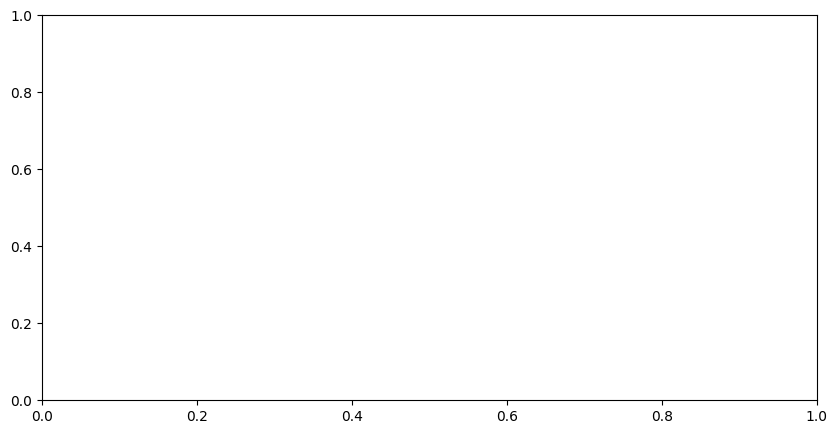

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import urllib.request
import os
import gzip
import shutil
import logging
import random
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, AutoModel
from gensim.models import Word2Vec
from thop import profile   

# 启用交互模式，便于实时更新图表
plt.ion()

# 设置日志记录，同时输出到文件
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch = logging.StreamHandler()
ch.setFormatter(formatter)
logger.addHandler(ch)
fh = logging.FileHandler("training.log")
fh.setFormatter(formatter)
logger.addHandler(fh)

# 设置随机种子
seed = 30
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# 设置计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 检测可用GPU数量
num_gpus = torch.cuda.device_count()
if num_gpus > 1:
    logger.info(f"Found {num_gpus} GPUs! Using distributed training.")
    use_multi_gpu = True
else:
    logger.info(f"Found {num_gpus} GPU. Using single GPU training.")
    use_multi_gpu = False

# -------------------------------
# 多GPU设置
# -------------------------------
def setup_ddp(rank, world_size):
    """
    设置分布式数据并行训练
    """
    if use_multi_gpu:
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '12355'
        torch.distributed.init_process_group(backend='nccl', init_method='env://', 
                                            world_size=world_size, rank=rank)
        torch.cuda.set_device(rank)

def cleanup_ddp():
    """
    清理分布式训练环境
    """
    if use_multi_gpu and torch.distributed.is_initialized():
        torch.distributed.destroy_process_group()

# -------------------------------
# 加载 word2vec 模型和分词器（异常处理）
# -------------------------------
# logger.info("Loading CodeBERT model and tokenizer...")
# try:
#     codebert_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
#     codebert_model = AutoModel.from_pretrained("microsoft/codebert-base")
#     codebert_model.to(device)
#     codebert_model.eval()
#     logger.info("CodeBERT loaded successfully!")
# except Exception as e:
#     logger.error("Failed to load word2vec model. Error: " + str(e))
#     raise e

# -------------------------------
# 超参数设置（针对 RTX 4090 优化后）
# -------------------------------
EMBEDDING_DIM = 300  # embedding 输出维度
W2VFILE = "./autodl-tmp/w2v.model"
W2VVECFILE = "./autodl-tmp/vec.npy"
FILTER_SIZES = [3, 4, 5]
NUM_FILTERS = 150
HIDDEN_DIM = 256
MATCH_COUNT = 240
DROPOUT_RATE = 0.5
LEARNING_RATE = 0.0005
EPOCHS = 10
K_FOLDS = 10
BATCH_SIZE = 2048
ACCUMULATION_STEPS = 1
MODEL_SAVE_PATH = "./models/"
TOP_K = 5
BATCH_MAX_LENGTH = 150

# -------------------------------
# 数据路径设置
# CSV 格式：第1列忽略，第2列为标签，第3列为产品，第4列为组件，第5列为 bug 描述
# -------------------------------
data_dir = "./data/data_by_ocean/Eclipse_raw/Segmented_content/Complete_data"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
# 定义保存嵌入数据的文件名
EMBEDDING_FILE = "./autodl-tmp/bug_embeddings.pt"

# -------------------------------
# 下载并解压词向量（备用，本例主要使用 CodeBERT）
# -------------------------------
# word2vec_path = "./autodl-fs/GoogleNews-vectors-negative300.bin"
# compressed_file = "./autodl-fs/GoogleNews-vectors-negative300.bin.gz"
# # if not os.path.exists(word2vec_path):
# #     logger.info("Downloading Word2Vec embeddings...")
# #     urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", compressed_file)
# #     logger.info("Download complete. Extracting file...")
# #     with gzip.open(compressed_file, 'rb') as f_in:
# #         with open(word2vec_path, 'wb') as f_out:
# #             shutil.copyfileobj(f_in, f_out)
# #     logger.info("File extracted successfully!")
# #     os.remove(compressed_file)
# # # logger.info("Loading Word2Vec embeddings...")
# word2vec = None  # 本例主要使用 CodeBERT

# -------------------------------
# 数据加载函数
# -------------------------------
def load_dataset(data_dir):
    label_list, product_list, component_list, bug_list = [], [], [], []
    label_encoder = LabelEncoder()
    product_encoder = LabelEncoder()
    component_encoder = LabelEncoder()
    
    for i in range(11):
        file_path = os.path.join(data_dir, f"{i}.csv")
        if os.path.exists(file_path):
            try:
                df = pd.read_csv(file_path)
                label_list.extend(df.iloc[:, 1].astype(str).tolist())
                product_list.extend(df.iloc[:, 2].astype(str).tolist())
                component_list.extend(df.iloc[:, 3].astype(str).tolist())
                bug_list.extend(df.iloc[:, 4].astype(str).tolist())
            except Exception as e:
                logger.error(f"Error reading {file_path}: {e}")
                continue
        else:
            logger.warning(f"File {file_path} does not exist.")
    
    labels_encoded = label_encoder.fit_transform(label_list)
    products_encoded = product_encoder.fit_transform(product_list)
    components_encoded = component_encoder.fit_transform(component_list)
    return labels_encoded, products_encoded, components_encoded, bug_list, label_encoder, product_encoder, component_encoder

# -------------------------------
# 文本转词嵌入函数
# -------------------------------
def text_to_embedding(text_list, max_length=BATCH_MAX_LENGTH):
    all_word_list = []
    # 第一步：构建词列表和文档频率统计
    word_doc_count = {}  # 记录每个词出现在多少文档中
    total_docs = len(text_list)
    logger.info(f"Computing IDF values for {total_docs} documents...")
    
    # 首先遍历所有文档，统计每个词的文档频率
    for i in range(0, len(text_list)):
        split_text_list = [item.strip().strip("'").strip("[").strip("]") for item in text_list[i].split(",")]
        # 对文本长度进行调整
        if (len(split_text_list) <= max_length):
            for i in range(len(split_text_list), max_length):
                split_text_list.append("pad")
        else:
            split_text_list = split_text_list[:max_length]
        
        # 统计每个词出现的文档数（每个文档中的每个词只计算一次）
        unique_words = set(split_text_list)
        for word in unique_words:
            if word in word_doc_count:
                word_doc_count[word] += 1
            else:
                word_doc_count[word] = 1
        
        all_word_list.append(split_text_list)
    
    # 第二步：计算IDF值
    word_idf = {}
    for word, doc_count in word_doc_count.items():
        # 使用log(N/df)计算IDF，加1平滑处理避免零除错误
        word_idf[word] = np.log(total_docs / (doc_count + 1)) + 1.0
    
    # 确保"pad"的IDF值为0
    word_idf["pad"] = 0.0
    
    logger.info(f"IDF calculation complete. Processing {len(all_word_list)} documents with Word2Vec...")
    print(len(all_word_list))
    
    # 第三步：加载或训练Word2Vec模型
    if os.path.exists(W2VFILE):
        w2v = Word2Vec.load(W2VFILE)
    else:
        w2v = Word2Vec(all_word_list,        #用于训练的语料数据
                    vector_size=300,    #是指特征向量的维度，默认为100
                    window=5,           #一个句子中当前单词和被预测单词的最大距离
                    min_count=1)        #可以对字典做截断，词频少于min_count次数的单词会被丢弃掉，默认值为5
        print(w2v.wv["javadoc"])
        w2v.wv["pad"] = np.zeros(300,dtype=np.float64)
        print(w2v.wv["pad"])
        print(len(w2v.wv["pad"]))
        w2v.save(W2VFILE)
    
    # 第四步：获取词嵌入并应用IDF加权
    flatA = np.array(all_word_list).reshape(-1)
    
    # 创建IDF加权的词嵌入
    idf_weighted_vectors = []
    for word in flatA:
        # 获取词嵌入
        word_vector = w2v.wv[word]
        # 获取IDF值并应用加权
        idf_value = word_idf.get(word, 1.0)  # 如果未知词，使用默认IDF=1
        # 应用IDF加权
        weighted_vector = word_vector * idf_value
        idf_weighted_vectors.append(weighted_vector)
    
    vectors = np.array(idf_weighted_vectors)
    logger.info(f"IDF-weighted word embeddings created with shape {vectors.shape}")
    print(vectors.shape)

    result_word_tensor = torch.from_numpy(vectors).reshape(-1, max_length, 300)
    print(result_word_tensor.shape)
    return result_word_tensor


# -------------------------------
# 定义增强型 Atten-CRNN 模型（包含产品和组件嵌入、残差链接与 SE 模块）
# -------------------------------
class AttenCRNNEnhanced(nn.Module):
    def __init__(self, num_classes, num_products, num_components):
        super(AttenCRNNEnhanced, self).__init__()
        self.convs3 = nn.Conv2d(1, NUM_FILTERS, (3, EMBEDDING_DIM))
        self.convs4 = nn.Conv2d(1, NUM_FILTERS, (4, EMBEDDING_DIM))
        self.convs5 = nn.Conv2d(1, NUM_FILTERS, (5, EMBEDDING_DIM))
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True, bidirectional=False)
        self.se_reduction = 16
        self.se_fc1 = nn.Linear(NUM_FILTERS * len(FILTER_SIZES), (NUM_FILTERS * len(FILTER_SIZES)) // self.se_reduction)
        self.se_fc2 = nn.Linear((NUM_FILTERS * len(FILTER_SIZES)) // self.se_reduction, NUM_FILTERS * len(FILTER_SIZES))
        
        self.product_embed = nn.Embedding(num_products, 32)
        self.component_embed = nn.Embedding(num_components, 32)
        
        self.total_feature_dim = NUM_FILTERS * len(FILTER_SIZES) + HIDDEN_DIM + 64
        
        self.fc1 = nn.Linear(self.total_feature_dim, MATCH_COUNT)
        self.residual = nn.Linear(self.total_feature_dim, MATCH_COUNT)
        self.fc2 = nn.Linear(MATCH_COUNT, num_classes)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        
    def forward(self, text_x, prod_idx, comp_idx):
        x = text_x.unsqueeze(1)  # (batch, 1, max_length, EMBEDDING_DIM)
        conv3features = F.relu(self.convs3(F.pad(x,(0,0,2,0)))).squeeze(3)    # (batch, NUM_FILTERS, max_length)
        conv4features = F.relu(self.convs4(F.pad(x,(0,0,3,0)))).squeeze(3)
        conv5features = F.relu(self.convs5(F.pad(x,(0,0,4,0)))).squeeze(3)
        cnn_features = torch.cat([conv3features, conv4features, conv5features], 1)  # (batch, NUM_FILTERS * len(FILTER_SIZES), max_length) batchsize 450 150
        cnn_features_atten = [F.max_pool1d(cnn_features, cnn_features.size(2)).squeeze(2)] # (batch, NUM_FILTERS * len(FILTER_SIZES))
        cnn_features_atten = torch.cat(cnn_features_atten, 1)
        se = F.relu(self.se_fc1(cnn_features_atten))  
        se = torch.sigmoid(self.se_fc2(se))
        se = se.unsqueeze(2).expand(-1, -1, cnn_features.size(2))  # (batch, NUM_FILTERS * len(FILTER_SIZES), max_length)
        cnn_features = cnn_features * se    # (batch, NUM_FILTERS * len(FILTER_SIZES))  batchsize 450
        
        lstm_out, _ = self.lstm(text_x) # (batch, max_length, HIDDEN_DIM)
        cross_attention = torch.bmm(cnn_features,lstm_out)  # Matrix multiplication is valid
        cross_attention = torch.softmax(cross_attention, dim=2)  # (batch, NUM_FILTERS * len(FILTER_SIZES), max_length)

        cross_attention_cnn = torch.bmm(cross_attention.permute(0,2,1), cnn_features)  # (batch, HIDDEN_DIM, max_length)
        cross_attention_lstm = torch.bmm(cross_attention, lstm_out.permute(0, 2, 1))  # (batch, NUM_FILTERS * len(FILTER_SIZES), HIDDEN_DIM)

        cross_attention = torch.cat((cross_attention_cnn, cross_attention_lstm), 1)
        cross_attention = F.max_pool1d(cross_attention, cross_attention.size(2)).squeeze(2)

        cross_attention = self.dropout(cross_attention)
        
        prod_emb = self.product_embed(prod_idx)
        comp_emb = self.component_embed(comp_idx)
        
        combined_features = torch.cat((cross_attention, prod_emb, comp_emb), 1)
        
        hidden = F.relu(self.fc1(combined_features) + self.residual(combined_features))
        output = self.fc2(hidden)
        return F.log_softmax(output, dim=1)

# -------------------------------
# 十折增量学习训练函数（引入 L2 正则化、梯度裁剪；记录当前学习率；优化评价方式与图表输出）
# -------------------------------
def ten_fold_incremental_learning(model, text_data, prod_data, comp_data, labels, label_encoder):
    evaluation_accuracies = []      
    evaluation_correct = []         
    evaluation_total = []           
    evaluation_true_probs = []      
    round_final_losses = []         

    loss_accuracy_fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # 如果使用多GPU，转换为DDP模型
    if use_multi_gpu:
        logger.info("Preparing model for multi-GPU training...")
        # 使用DataParallel包装模型 - 简单方式
        model = nn.DataParallel(model)
        logger.info(f"Model wrapped with DataParallel across {num_gpus} GPUs")

    for i in range(1, 11):
        # if i>=5: exit()
        try:
            test_text = text_data[i]
            test_labels = labels[i]
            test_prod = prod_data[i]
            test_comp = comp_data[i]
        except IndexError as e:
            logger.error(f"Data partition index error: {e}")
            break
        
        print("Initializing dataloader")
        train_dataset = TensorDataset(torch.cat(text_data[:i]), torch.cat(prod_data[:i]), torch.cat(comp_data[:i]), torch.cat(labels[:i]))
        test_dataset = TensorDataset(test_text, test_prod, test_comp, test_labels)
        
        # 调整批大小以适应多GPU训练
        effective_batch_size = BATCH_SIZE
        if use_multi_gpu:
            # 确保每个GPU获得相同大小的批次
            effective_batch_size = BATCH_SIZE * num_gpus
            logger.info(f"Using effective batch size: {effective_batch_size} ({BATCH_SIZE} per GPU)")
        
        train_loader = DataLoader(train_dataset, batch_size=effective_batch_size, shuffle=True, 
                                 pin_memory=True, num_workers=4 if use_multi_gpu else 2)
        test_loader = DataLoader(test_dataset, batch_size=effective_batch_size, shuffle=False, 
                                pin_memory=True, num_workers=4 if use_multi_gpu else 2)
        print("Dataloader initialized")
        
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
        
        model.train()
        optimizer.zero_grad()
        batch_count = 0
        epoch_losses = []
        
        for epoch in range(EPOCHS):
            epoch_loss = 0.0
            num_batches = 0
            for batch in tqdm(train_loader, desc=f"Round {i} Epoch {epoch+1}/{EPOCHS}", leave=False):
                num_batches += 1
                batch_count += 1
                batch_text, batch_prod, batch_comp, batch_Y = [b.to(device) for b in batch]
                with torch.cuda.amp.autocast():
                    outputs = model(batch_text, batch_prod, batch_comp)
                    loss = F.cross_entropy(outputs, batch_Y) / ACCUMULATION_STEPS
                loss.backward()
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                epoch_loss += loss.item() * ACCUMULATION_STEPS
                if batch_count % ACCUMULATION_STEPS == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                    batch_count = 0
            if batch_count != 0:
                optimizer.step()
                optimizer.zero_grad()
                batch_count = 0
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            avg_epoch_loss = epoch_loss / num_batches
            epoch_losses.append(avg_epoch_loss)
            logger.info(f"Round {i}, Epoch {epoch+1}/{EPOCHS}: Avg Loss = {avg_epoch_loss:.4f}, LR = {current_lr:.6f}")
        
        round_final_losses.append(epoch_losses[-1])
        
        ax1.cla()
        ax1.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o', color='blue', label='Training Loss')
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Training Loss", color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        model.eval()
        correct_count = 0
        total_count = 0
        true_prob_sum = 0.0
        y_pred_names = []
        with torch.no_grad():
            for batch in test_loader:
                batch_text, batch_prod, batch_comp, batch_Y = [b.to(device) for b in batch]
                outputs = model(batch_text, batch_prod, batch_comp)
                probs = torch.exp(outputs)
                topk_probs, topk_indices = torch.topk(probs, TOP_K, dim=1)
                batch_Y_np = batch_Y.cpu().numpy()
                for j in range(topk_indices.size(0)):
                    candidates = topk_indices[j].cpu().numpy()
                    candidate_probs = topk_probs[j].cpu().numpy()
                    total_count += 1
                    if batch_Y_np[j] in candidates:
                        correct_count += 1
                        idx = np.where(candidates == batch_Y_np[j])[0][0]
                        true_prob_sum += candidate_probs[idx]
                    else:
                        true_prob_sum += 0.0
                    y_pred_names.append(label_encoder.inverse_transform([candidates[0]])[0])
        round_accuracy = correct_count / total_count if total_count > 0 else 0
        avg_true_prob = true_prob_sum / total_count if total_count > 0 else 0
        
        evaluation_accuracies.append(round_accuracy)
        evaluation_correct.append(correct_count)
        evaluation_total.append(total_count)
        evaluation_true_probs.append(avg_true_prob)
        
        logger.info(f"Round {i} - TOP_K Evaluation: Correct Predictions: {correct_count}, Total Predictions: {total_count}, TOP_K Accuracy: {round_accuracy:.4f}")
        logger.info(f"Round {i} - Sample predicted bug fixers (top candidate, top 10): {y_pred_names[:TOP_K]}")
        
        # 保存模型时，处理多GPU模型的保存
        if use_multi_gpu:
            model_to_save = model.module  # 获取DataParallel中包装的原始模型
        else:
            model_to_save = model
            
        checkpoint = {
            'epoch': EPOCHS,
            'model_state_dict': model_to_save.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': epoch_losses[-1]
        }
        if round_accuracy > max(evaluation_accuracies[:-1], default=0):
            checkpoint_path = os.path.join(MODEL_SAVE_PATH, f"model_round_{i}_best.pth")
            torch.save(checkpoint, checkpoint_path)
            logger.info(f"New best model saved at {checkpoint_path}")
        latest_path = os.path.join(MODEL_SAVE_PATH, f"model_round_{i}_latest.pth")
        torch.save(checkpoint, latest_path)
        logger.info(f"Latest model for Round {i} saved at {latest_path}")
    
    final_accuracy = np.mean(evaluation_accuracies) if evaluation_accuracies else 0
    logger.info("Final Evaluation (Avg over 10 rounds): Accuracy: {:.4f}".format(final_accuracy))
    
    rounds = range(1, len(evaluation_accuracies) + 1)
    fig, ax1 = plt.subplots(figsize=(10, 5))
    color_loss = 'tab:blue'
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Final Training Loss', color=color_loss)
    ax1.plot(rounds, round_final_losses, marker='o', color=color_loss, label='Training Loss')
    ax1.tick_params(axis='y', labelcolor=color_loss)
    
    ax2 = ax1.twinx()
    color_acc = 'tab:red'
    ax2.set_ylabel('TOP_K Accuracy', color=color_acc)
    ax2.plot(rounds, evaluation_accuracies, marker='s', color=color_acc, label='TOP_K Accuracy')
    ax2.tick_params(axis='y', labelcolor=color_acc)
    
    fig.tight_layout()
    plt.title("Final Training Loss and TOP_K Accuracy per Round")
    plt.grid(True)
    plt.show()
    plt.ioff()
    
    # 清理多GPU环境
    if use_multi_gpu:
        cleanup_ddp()

# -------------------------------
# 主流程：加载数据、转换，并输出一次数据集详细参数信息
# CSV 文件假设包含5列：第1列忽略，第2列为标签，第3列为产品，第4列为组件，第5列为 bug 描述
# -------------------------------
labels_encoded, products_encoded, components_encoded, bug_list, label_encoder, product_encoder, component_encoder = load_dataset(data_dir)

# 检查本地是否存在预先保存的 bug 描述嵌入数据
if os.path.exists(EMBEDDING_FILE):
    logger.info("Loading precomputed bug embeddings from local file...")
    bug_tensor_full = torch.load(EMBEDDING_FILE)
else:
    logger.info("Computing bug embeddings using word2vec...")
    bug_tensor_full = text_to_embedding(bug_list)
    torch.save(bug_tensor_full, EMBEDDING_FILE)
    logger.info("Bug embeddings saved to local file.") 

prod_tensor_full = torch.tensor(products_encoded, dtype=torch.long)
comp_tensor_full = torch.tensor(components_encoded, dtype=torch.long)
label_tensor_full = torch.tensor(labels_encoded, dtype=torch.long)

logger.info("Bug Text Tensor Shape: " + str(bug_tensor_full.shape))
logger.info("Product Tensor Shape: " + str(prod_tensor_full.shape))
logger.info("Component Tensor Shape: " + str(comp_tensor_full.shape))
logger.info("Label Tensor Shape: " + str(label_tensor_full.shape))

num_parts = 11
bug_splits = torch.chunk(bug_tensor_full, num_parts)
prod_splits = torch.chunk(prod_tensor_full, num_parts)
comp_splits = torch.chunk(comp_tensor_full, num_parts)
label_splits = torch.chunk(label_tensor_full, num_parts)

# 添加显存优化选项
torch.backends.cudnn.benchmark = True  # 启用cudnn自动调优
torch.backends.cudnn.deterministic = False  # 允许非确定性优化

model = AttenCRNNEnhanced(num_classes=len(label_encoder.classes_),
                          num_products=len(product_encoder.classes_),
                          num_components=len(component_encoder.classes_)).to(device)



model.eval()

# 2. 统计参数量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"模型可训练参数量: {total_params / 1e6:.2f} M")

# 3. 统计 FLOPs（以单样本输入为例）
#    输入维度: (batch_size=1, seq_len=BATCH_MAX_LENGTH, embed_dim=EMBEDDING_DIM)
dummy_text = torch.randn(1, BATCH_MAX_LENGTH, EMBEDDING_DIM).to(device)
dummy_prod = torch.zeros(1, dtype=torch.long).to(device)
dummy_comp = torch.zeros(1, dtype=torch.long).to(device)

flops, params = profile(
    model, 
    inputs=(dummy_text, dummy_prod, dummy_comp),
    verbose=False
)
print(f"FLOPs: {flops / 1e9:.3f} G  |  参数量 (thop 计算): {params / 1e6:.2f} M")


# 添加多GPU分布式训练的入口点函数
def main_worker():
    """主进程工作函数，用于启动分布式训练"""
    ten_fold_incremental_learning(model, bug_splits, prod_splits, comp_splits, label_splits, label_encoder)

if __name__ == "__main__":
    # 单机多卡训练入口
    if use_multi_gpu:
        # 使用DataParallel模式直接调用
        main_worker()
    else:
        # 单GPU模式
        ten_fold_incremental_learning(model, bug_splits, prod_splits, comp_splits, label_splits, label_encoder)